In [2]:
import sys
import flap

sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\utility")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\utility")
import convert_dict_to_flap
sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\core")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\core")
import core

INIT flap storage


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cmath
gi=0

E:\marci main\fusion\inputdata\AUGD_32326_085-095_balltor.sav
(9, 200001)
[0.85      0.8500005 0.850001  ... 0.949999  0.9499995 0.95     ]
MHF-B17-02

-----------------------------
<1>(data_source:"" exp_id:"AUGD-32326") data_title:"raw data" shape:[9,200001][no error]
  Data name:"unit", unit:"a.u."
  Coords:
    'Time [s](Dims:1, Shape:[200001]) [<R. symm.>] Val. range:  8.500E-01 -  9.500E-01
    'Channels [a.u.](Dims:0, Shape:[9]) [<R. symm.>] Val:MHF-B17-02, MHF-B31-40, MHA-B31-14, MHA-B31-03, MHA-B31-01, MHA-B31-02, MHA-B31-12, MHH-B31-22, MHA-B31-13
    'Theta [rad](Dims:0, Shape:[9]) [<R. symm.>] Val: 6.164E+00,  6.126E+00,  6.176E+00,  6.171E+00,  6.175E+00,  6.181E+00,  6.169E+00,  6.123E+00,  6.164E+00
    'Phi [rad](Dims:0, Shape:[9]) [<R. symm.>] Val: 1.524E+00,  2.791E+00,  3.590E+00,  4.746E+00,  4.796E+00,  5.184E+00,  5.747E+00,  5.969E+00,  6.791E+00
4000020.0000000014


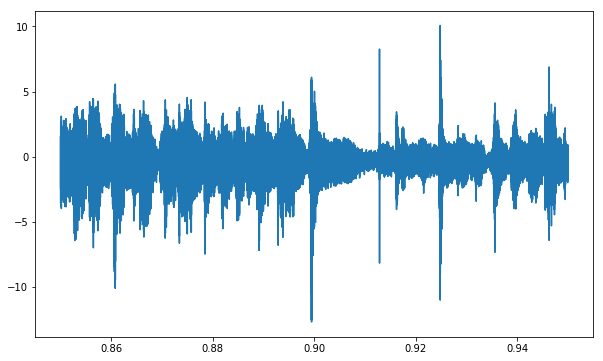

In [4]:
#%%script false
path = r"E:\marci main\fusion\inputdata\AUGD_32326_085-095_balltor.sav"
print(path)

obj = core.NWTDataObject()
obj.load_raw_sav(path)
print(obj.raw_data.data.shape)
print(obj.raw_data.coordinates[0].values)
print(obj.raw_data.coordinates[1].values[0])
flap.list_data_objects(obj.raw_data)

prefix_str = "AUGD_"

samples = obj.raw_data.data.shape[1]
#f=500
tmin=min(obj.raw_data.coordinates[0].values)
tmax=max(obj.raw_data.coordinates[0].values)
t=tmax-tmin
s_rate=t/samples
nyquist=2/s_rate
print(nyquist)

x = np.linspace(start=tmin,num=samples,stop=tmax)
data = obj.raw_data.data[0]
plt.figure(figsize=(10,6))
plt.plot(x,data)

In [28]:
def get_ridge(stft, i_center=0, search_r=10, include_r = 80, ): 
    # returns the indices of the ridge
    if i_center == 0:
        i_center = np.argmax(np.abs(stft[:,0]))
     #if i_center_is_in_frequency: i_center=int(i_center*viewf_i/nyquist)
    if i_center < include_r:
        i_center = include_r
    
    ridgei=np.zeros(stft.shape[1])
    ridge_amp=np.zeros(stft.shape[1],dtype=complex)
    
    search_area=np.abs(stft[i_center-include_r:i_center+include_r])
    ridgei[0]=np.argmax(search_area[:,0])
    for i in range(1,stft.shape[1]):
        ridgei[i]=np.argmax(search_area[:,i])
        ridge_amp[i]=stft[int(ridgei[i]+i_center-include_r),i]
    ridgei=ridgei+i_center-include_r
    
    return ridgei, ridge_amp

def rice_region_fit(stft, f1, f2, t1=0, t2=stft.shape[1]):
    #fits a rician noise to the abs of a region of an an stft.
    #returns fit parameters
    #user should select a region where only white noise or stationary signal is present
    
    #if t2==-1:
    #    t2=stft.shape[1]
    
    amplitude=np.abs(stft[f1:f2,t1:t2]).flatten()
    shape,loc,sigma=scipy.stats.rice.fit(amplitude)
    
    return shape,loc,sigma

<ErrorbarContainer object of 3 artists>

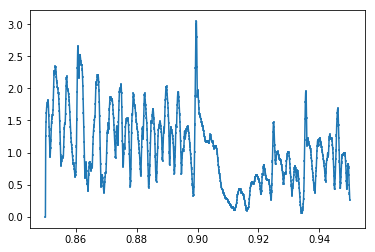

In [31]:
n = int(3*2*samples**0.5)
len_fft = 3*n
fft_jump=200
f_ax, t_ax, stft = scipy.signal.stft(data, nperseg=n, noverlap = n-fft_jump, nfft = len_fft)
t_ax=t_ax/samples*t+tmin
stft=stft*2

ridgei, ridge_amp = get_ridge(stft, i_center=int(100000*viewf_i/nyquist))

shape,loc,sigma = rice_region_fit(stft, int(20*1000*viewf_i/nyquist), int(60*1000*viewf_i/nyquist))

plt.errorbar(t_ax,np.abs(ridge_amp),sigma,label="Amplitúdó")

2683
a 201
201
120
40


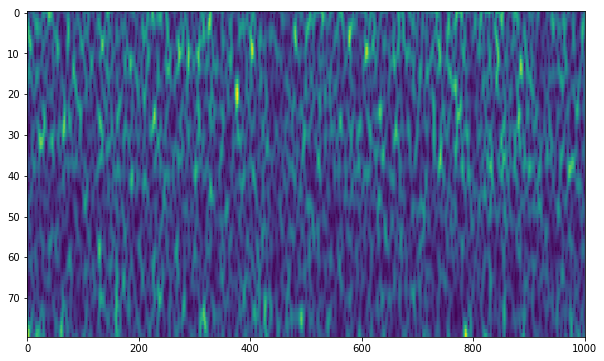

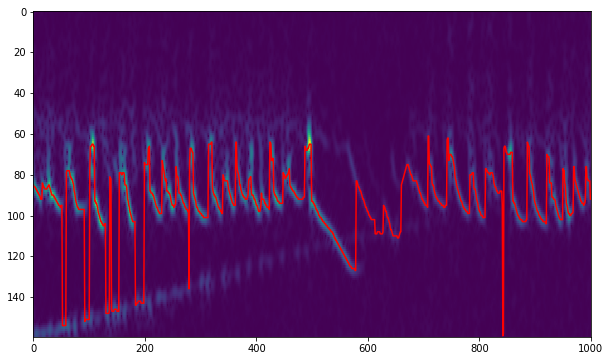

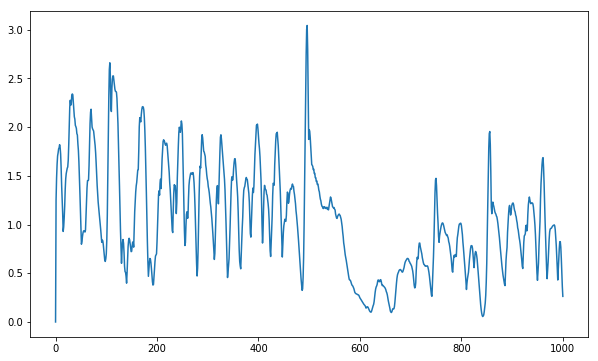

In [9]:
#%%script false

n = int(3*2*samples**0.5)
len_fft = 3*n
fft_jump=200
print(n)
f_ax, t_ax, stft = scipy.signal.stft(data, nperseg=n, noverlap = n-fft_jump, nfft = len_fft)
t_ax=t_ax/samples*t+tmin
stft=stft*2

#ridge following
ridgei=np.zeros(len(t_ax))
ridge_amp=np.zeros(len(t_ax),dtype=complex)#
stft_abs=np.abs(stft)
viewf_i=len_fft

search_r=10
include_r=80
i_center=int(100000*viewf_i/nyquist) #i=f/wievf_i*nyquist
print("a",i_center)
print(i_center)

search_r=int(search_r)
search_area=np.abs(stft[i_center-include_r:i_center+include_r])
ridgei[0]=np.argmax(search_area[:,0])
for i in range(1,len(t_ax)):
    if i%10000 == 0:
        print(ridgei[i-1])
    ridgei[i]=np.argmax(search_area[:,i])
    ridge_amp[i]=stft[int(ridgei[i]+i_center-include_r),i]
#print(np.abs(ridge_amp))
ridgei=ridgei+i_center-include_r

f1=60
f2=20
f_i1=int(f1*1000*viewf_i/nyquist)
print(f_i1)
f_i2=int(f2*1000*viewf_i/nyquist)
print(f_i2)
randrange_x=[tmin,tmin,tmax,tmax,tmin]
randrange_y=[f2,f1,f1,f2,f2]

#plotting
plt.figure(figsize=(10,6))
plt.imshow(np.abs(stft[f_i2:f_i1]),aspect='auto')
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(search_area,aspect='auto')
plt.plot(ridgei-i_center+include_r,'r')#t_ax,
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.abs(ridge_amp))
plt.show()

102602.0784196795
13415 4000020.0000000014


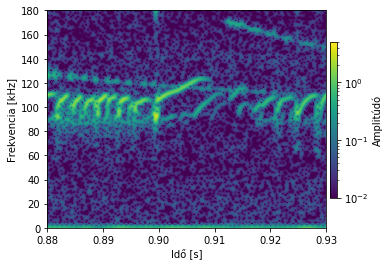

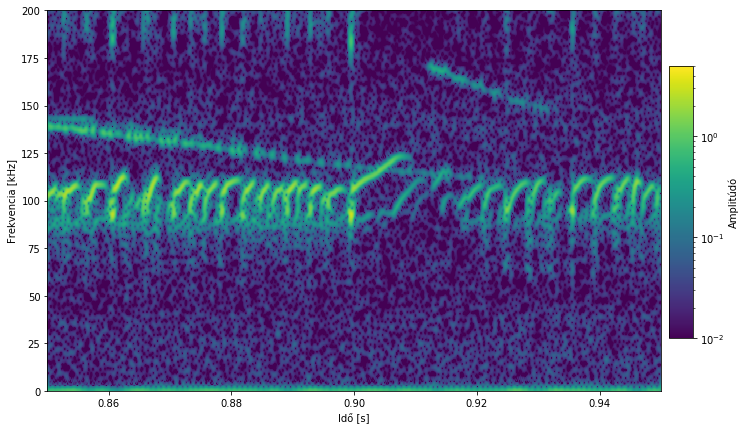

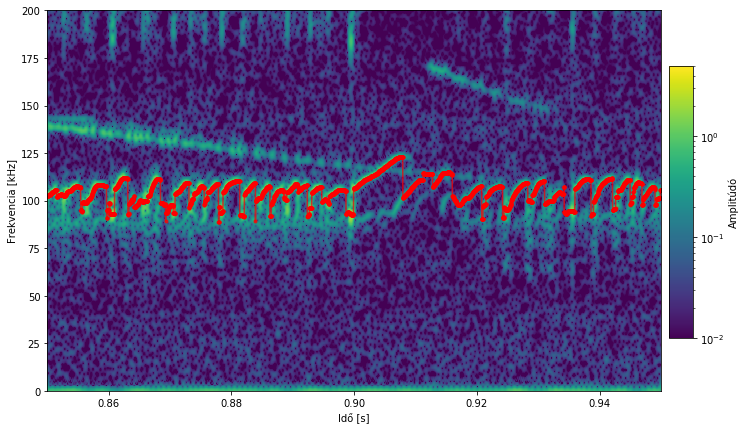

In [6]:
wievd=samples
wievf_i=len_fft
print(np.average(ridgei[:10])/wievf_i*nyquist)
print(len_fft,nyquist)

import matplotlib.colors as colors
colornorm=colors.LogNorm(vmin=0.01, vmax=5)

plt.figure(figsize=(5,4))
plt.imshow(np.abs(stft[:wievf_i,:wievd]),aspect='auto',extent = [tmin,tmax,nyquist/2000,0],norm=colornorm)#,cmap='plasma' ,/len_fft*nyquist,0]
#plt.plot(t_ax,ridgei[:wievd]/wievf_i*nyquist/1000,'r.-',alpha=0.7)#/len_fft*nyquist,"r.-"#*wievf*len_fft/s_rate
#plt.plot(randrange_x,randrange_y,'y.-',linewidth=4)
plt.ylim(0,180)
plt.xlim(0.88,0.93)
plt.ylabel("Frekvencia [kHz]")
plt.xlabel("Idő [s]")
cax = plt.axes([0.91, 0.23, 0.02, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig(prefix_str+"ridge_range", dpi =600)
plt.show()

plt.figure(figsize=(11,7))
plt.imshow(np.abs(stft[:wievf_i,:wievd]),aspect='auto',extent = [tmin,tmax,nyquist/2000,0],norm=colornorm)#,cmap='plasma' ,/len_fft*nyquist,0]
#plt.plot(t_ax,ridgei[:wievd]/wievf_i*nyquist/1000,'r.-',alpha=0.7)#/len_fft*nyquist,"r.-"#*wievf*len_fft/s_rate
#plt.plot(randrange_x,randrange_y,'y.-',linewidth=4)
plt.ylim(0,200)
#plt.xlim(0,4)
plt.ylabel("Frekvencia [kHz]")
plt.xlabel("Idő [s]")
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig(prefix_str+"stft", dpi =600)
plt.show()

plt.figure(figsize=(11,7))
plt.imshow(np.abs(stft[:wievf_i,:wievd]),aspect='auto',extent = [tmin,tmax,nyquist/2000,0],norm=colornorm)#,cmap='plasma' ,/len_fft*nyquist,0]
plt.plot(t_ax,ridgei[:wievd]/wievf_i*nyquist/1000,'r.-',alpha=0.7)#/len_fft*nyquist,"r.-"#*wievf*len_fft/s_rate
#plt.plot(randrange_x,randrange_y,'y.-',linewidth=4)
plt.ylim(0,200)
#plt.xlim(0,4)
plt.ylabel("Frekvencia [kHz]")
plt.xlabel("Idő [s]")
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig(prefix_str+"ridge", dpi =600)
plt.show()

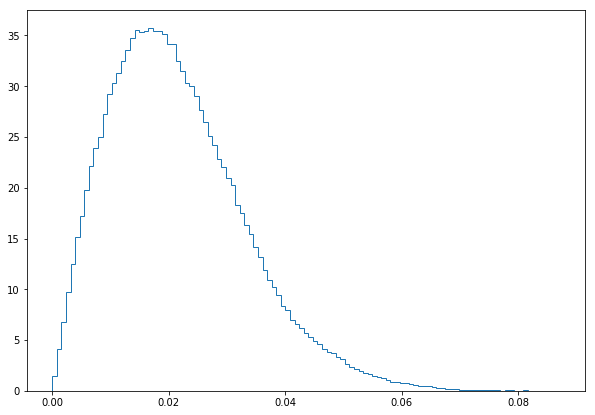

In [7]:
#c = np.abs(chosen).flatten()
#c = chosen.real.flatten()stft[0:15,0:1500]
#print(amplitude[200])

#np.seterr(divide='ignore', invalid='ignore')
amplitude=np.abs(stft[f_i2:f_i1]).flatten()#int(np.average(ridgei))-25  


plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(np.abs(amplitude), bins=111, density = True,facecolor='b',histtype='step')#4.2,4.7,range=(0.7,1.3
#plt.xlim(4.2,4.7)
plt.savefig("hist", dpi =360)
plt.show()
dist_x=bins[:-1]/2+bins[1:]/2

In [8]:
locg, stdg = scipy.stats.norm.fit(np.abs(amplitude))#,loc=0.5
shape_r,loc_r,scale_r=scipy.stats.rice.fit(np.abs(amplitude))#,floc=0

print("Amplitúdó Rice eloszlással: ",shape_r*scale_r+loc_r, ",  Var: ", np.sqrt(scale_r))
print("Amplitúdó Gauss eloszlással: ",locg, ",  Var: ", np.sqrt(stdg))

normfit


Zaj:
0.05388128799561231 0.028243855123431433
0.0012425123713100464 0 0.04301689031333428
Amplitúdó Rice eloszlással:  5.3449018389605135e-05
Amplitúdó Gauss eloszlással:  0.05388128799561231 ,  Var:  0.16805908224023905

Jel:
0.9938795615182778 0.049566682596736786
20.013851182443467 0 0.04959763968882898
Amplitúdó Rice eloszlással:  0.9926397797326749
Amplitúdó Gauss eloszlással:  0.9938795615182778 ,  Var:  0.22263576216937114

60.50510400665242
1.0536158706601582
0.017413669275641856
0.0
22.9097517570519


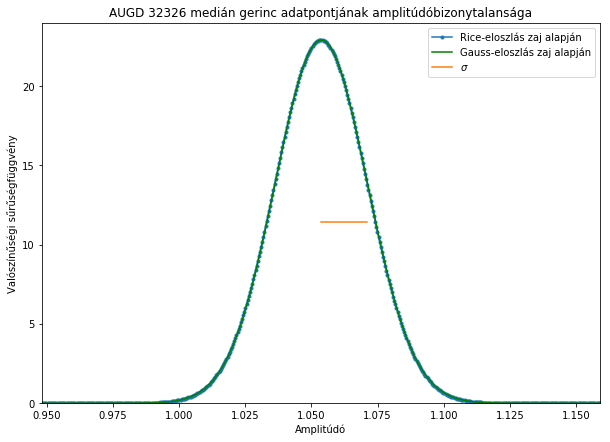

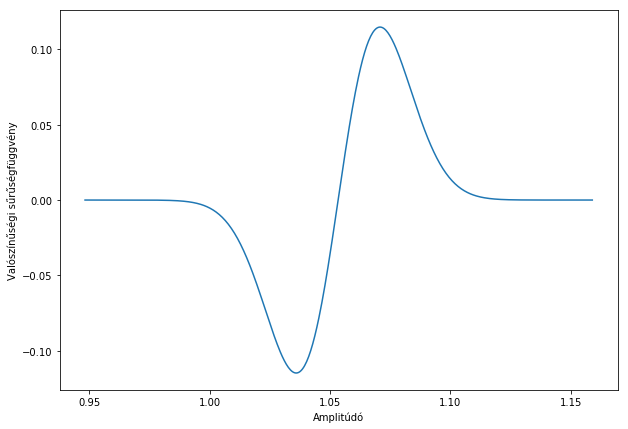

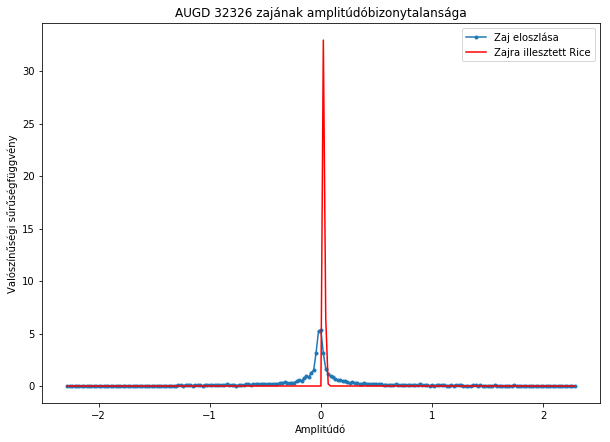

In [39]:
s2=scale_r#0.04301689031333428
v2=np.mean(np.abs(ridge_amp))
loc2=loc_r
print(v2/s2)
print(v2)
print(s2)
print(np.min(np.abs(ridge_amp)))

x2=np.linspace(start=v2*0.9,num=500,stop=v2*1.1)
distmax=np.max(scipy.stats.rice.pdf(x2,v2/s2,loc2,s2))
print(distmax)

plt.figure(figsize=(10,7))
#plt.plot(dist_x,n,'.-')
#plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape_r,loc_r,scale_r),'r.-') 
plt.plot(x2,scipy.stats.rice.pdf(x2,v2/s2,loc2,s2),'.-',label="Rice-eloszlás zaj alapján") 
plt.plot(x2,scipy.stats.norm.pdf(x2,loc=v2-loc2,scale=s2),'g-',label="Gauss-eloszlás zaj alapján")
#plt.plot([v2-loc2,v2-loc2+s2*1.17741],[distmax/2,distmax/2],label="FWHM/2 = $1.177*\sigma$")#
#plt.plot([v2-loc2,v2-loc2+s2],[distmax,distmax],label="$\sigma$")#
plt.plot([v2-loc2,v2-loc2+s2],[distmax/2,distmax/2],label="$\sigma$")#
plt.xlim(v2*0.9,v2*1.1)
plt.ylim(0,24)
plt.title("AUGD 32326 medián gerinc adatpontjának amplitúdóbizonytalansága")
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
plt.legend()
plt.savefig(prefix_str+"compare3", dpi =400)
plt.show()

plt.figure(figsize=(10,7))
#plt.plot(dist_x,n,'.-')
x2=np.linspace(start=v2*0.9,num=500,stop=v2*1.1)
#plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape_r,loc_r,scale_r),'r.-') 
plt.plot(x2,(scipy.stats.rice.pdf(x2,v2/s2,loc2,s2)-scipy.stats.norm.pdf(x2,loc=v2+loc2,scale=s2)),'-') 
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
#plt.savefig("diff"+str(gi))
plt.show()

plt.figure(figsize=(10,7))
plt.plot(dist_x,n,'.-',label="Zaj eloszlása")
plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape_r,loc_r,scale_r),'r-',label="Zajra illesztett Rice") 
#plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,v2/s2,0,s2),'-') 
#plt.plot(dist_x,scipy.stats.norm.pdf(dist_x,loc=locg,scale=stdg),'g-') 
plt.title("AUGD 32326 zajának amplitúdóbizonytalansága")
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
plt.legend()
#plt.savefig(prefix_str+"norm_compare", dpi =400)
plt.show()

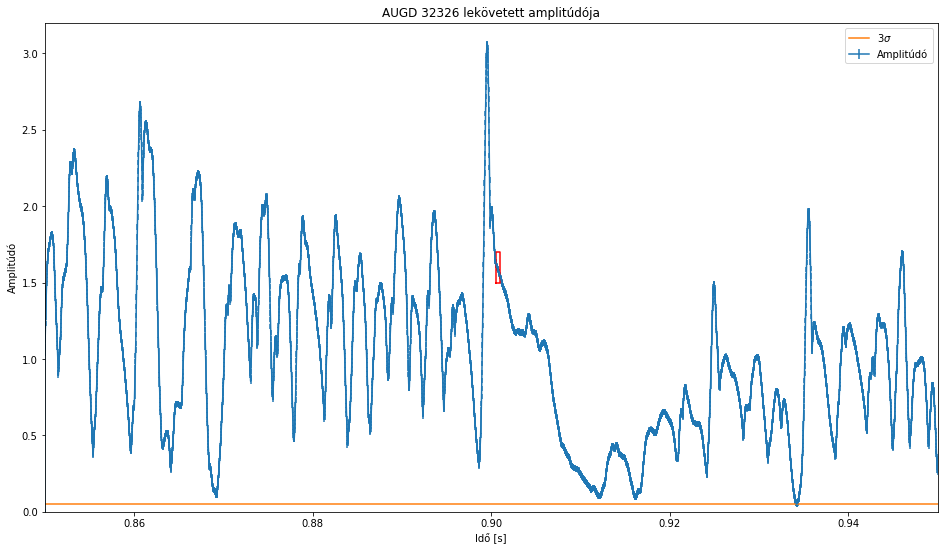

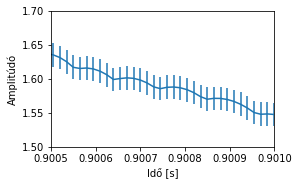

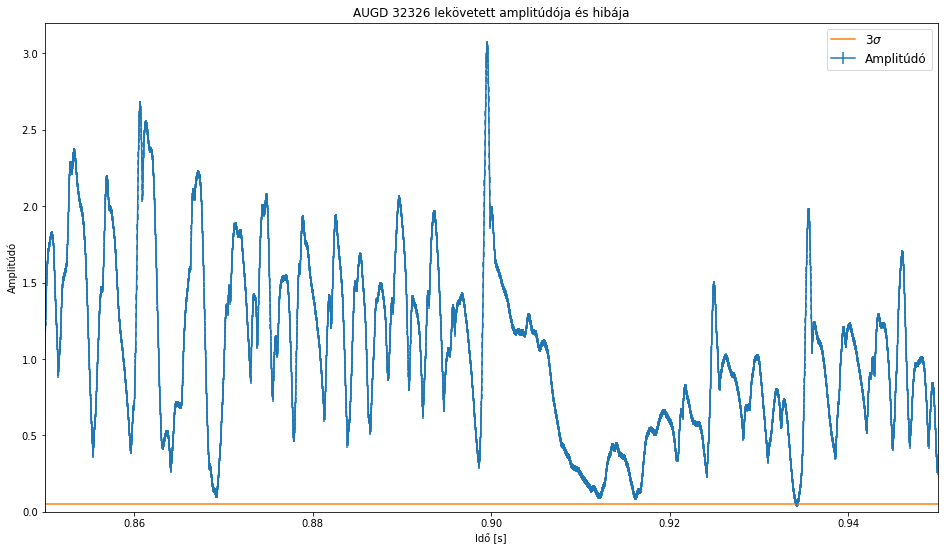

In [11]:
t1=0.9005
t2=0.901
z1=1.5
z2=1.7

plt.figure(figsize=(16,9))
#plt.plot(t_ax,np.abs(ridge_amp),'-')
plt.errorbar(t_ax,np.abs(ridge_amp),s2,label="Amplitúdó")
plt.plot([t_ax[0],t_ax[-1]],[3*s2,3*s2],label="$3\sigma$")
plt.ylabel("Amplitúdó")
plt.xlabel("Idő [s]")
plt.xlim(0.85,0.95)
plt.plot([t1,t1,t2,t2,t1],[z1,z2,z2,z1,z1],"r")
plt.ylim(0,3.2)
plt.legend()
plt.title("AUGD 32326 lekövetett amplitúdója")
plt.savefig(prefix_str+"amp0", dpi =400)
plt.show()


plt.figure(figsize=(4,2.5))
#plt.plot(t_ax,np.abs(ridge_amp),'.-')
plt.errorbar(t_ax,np.abs(ridge_amp),s2,label="Amplitúdó")
plt.plot([t_ax[0],t_ax[-1]],[3*s2,3*s2],label="$3\sigma$")
#plt.plot(t_ax,np.abs(ridge_amp)+s2,'b-')
#plt.plot(t_ax,np.abs(ridge_amp)-s2,'b-')
#plt.title("AUGD 32326 lekövetett amplitúdója és hibája")
#plt.legend(fontsize=12)
plt.ylabel("Amplitúdó")
plt.xlabel("Idő [s]")
plt.xlim(t1,t2)
plt.ylim(z1,z2)
#plt.xlim(0.85,0.95)
#plt.ylim(0,3.2)
plt.savefig(prefix_str+"ampz", dpi =400)
plt.show()

plt.figure(figsize=(16,9))
#plt.plot(t_ax,np.abs(ridge_amp),'.-')
plt.errorbar(t_ax,np.abs(ridge_amp),s2,label="Amplitúdó")
plt.plot([t_ax[0],t_ax[-1]],[3*s2,3*s2],label="$3\sigma$")
#plt.plot(t_ax,np.abs(ridge_amp)+s2,'b-')
#plt.plot(t_ax,np.abs(ridge_amp)-s2,'b-')
plt.ylabel("Amplitúdó")
plt.xlabel("Idő [s]")
plt.xlim(0.85,0.95)
plt.ylim(0,3.2)
plt.legend(fontsize=12)
plt.title("AUGD 32326 lekövetett amplitúdója és hibája")
#plt.savefig(prefix_str+"amp", dpi =600)
plt.show()

In [12]:
len_amp = len(np.abs(ridge_amp))
avg_diff=0
for i in range(len_amp-1):
    avg_diff = avg_diff+np.abs(np.abs(ridge_amp[i])-np.abs(ridge_amp[i+1]))/len_amp
print(avg_diff)
print(s2)
print(avg_diff/s2)

0.011316555044408625
0.017413669275641856
0.6498661979435982


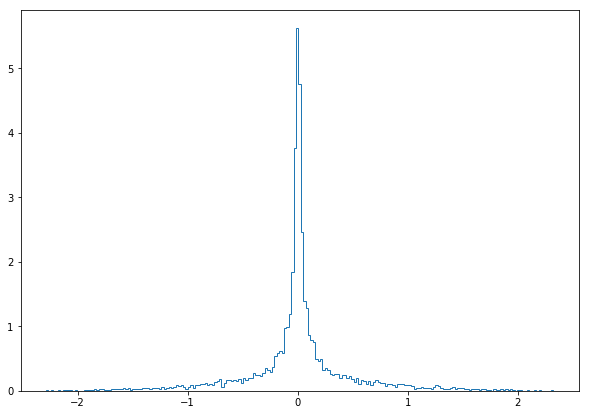

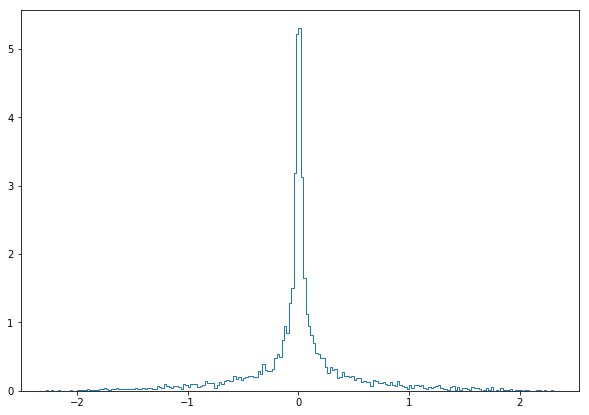

In [13]:
amp_im = stft[int(np.average(ridgei))].imag.flatten()
amp_re = stft[int(np.average(ridgei))].real.flatten()

plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(amp_re, bins=211, density = True,facecolor='b',histtype='step')#4.2,4.7,range=(0.7,1.3)
#plt.xlim(4.2,4.7)
plt.savefig("hist_re")
plt.show()
dist_x=bins[:-1]

plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(amp_im, bins=211, density = True,facecolor='b',histtype='step')#4.2,4.7,range=(0.7,1.3)
#plt.xlim(4.2,4.7)
plt.show()
dist_x=bins[:-1]

loc_im, std_im = scipy.stats.norm.fit(amplitude.imag)
loc_re, std_re = scipy.stats.norm.fit(amplitude.real)

In [14]:
%%script false
max = np.max(np.abs(stft))
plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.abs(stft), vmin=0, vmax=max, shading='plasma')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_abs")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.real, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Real')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_real")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.imag, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Imag')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_imag")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.angle(stft), vmin=-6, vmax=6, shading='plasma')
plt.title('STFT Phase')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_phase")
plt.show()

Couldn't find program: 'false'


In [15]:
%%script false
shape_h=25
scale_h=25
loc_h=18
diff = np.zeros((shape_h,scale_h,loc_h))
shape = np.linspace(0,8,shape_h)
scale = np.linspace(0.04,0.10,scale_h)
loc = np.linspace(0.0,0.6,loc_h)
for i in range(shape_h):
    for j in range(scale_h):
        for k in range(loc_h):
            diff[i,j,k] = np.average((scipy.stats.rice.pdf(dist_x,shape[i],loc[k],scale[j])-n)**2)
    if i%2 == 0:
        print(i)
#print(divmod(diff.argmin(), diff.shape[1]))

#mini = np.min(diff)
x1,y1,z1=np.unravel_index(diff.argmin(), diff.shape)
print(x1,y1,z1)
print(shape[x1],scale[y1],loc[z1])

plt.figure(figsize=(14,11))
plt.imshow(diff[:,:,z1],aspect='auto')
plt.plot(y1,x1,'ro')
plt.ylabel("shape")
plt.xlabel("scale")
plt.show()

Couldn't find program: 'false'
